# Metrics for GPLVM

This notebook introduces the use of a probabilistic geometries approach in the context of Gaussian processes latent variable models, presenting examples of learning a GPLVM and Bayesian GPLVMs on data and show the latent embedding. Especially the magnification factor and what it says about the latent space.

Authors: *Alessandra Tosi, Max Zwiessele*

Note: Requires GPy Version >= 0.8

In [1]:
import numpy as np
%matplotlib inline
from matplotlib import pyplot as plt
import GPy # import GPy package
np.random.seed(12345)

## Introduction to the visualization tools

We investigate the expected metric of the latent space of GPLVM with exponentiated quadratic kernel. We use a toy example given by an training space $\mathbf{Y}$ of three 10-dimensional random Gaussian clusters. The latent space $\mathbf{X}$ is chosen to be 2-dimensional for a visualization purpose.

In [2]:
# Define dataset 
N = 100
k1 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[10,10,10,0.1,0.1]), ARD=True)
k2 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[10,0.1,10,0.1,10]), ARD=True)
k3 = GPy.kern.RBF(5, variance=1, lengthscale=1./np.random.dirichlet(np.r_[0.1,0.1,10,10,10]), ARD=True)
X = np.random.normal(0, 1, (N, 5))
A = np.random.multivariate_normal(np.zeros(N), k1.K(X), 10).T
B = np.random.multivariate_normal(np.zeros(N), k2.K(X), 10).T
C = np.random.multivariate_normal(np.zeros(N), k3.K(X), 10).T

Y = np.vstack((A,B,C))
labels = np.hstack((np.zeros(A.shape[0]), np.ones(B.shape[0]), np.ones(C.shape[0])*2))

input_dim = 2 # How many latent dimensions to use
kernel = GPy.kern.RBF(input_dim, 1, ARD=True) 

For a test point $x_*$ we can compute the following quantities:

$$ \mathbf{J} \sim \prod_p \mathcal{N}( \partial\mathbf{K}_{*,f}\mathbf{K}_{f,f}^{-1}\mathbf{Y}_{:,p}, \partial^2\mathbf{K}_{*,*} - \partial\mathbf{K}_{*,f}\mathbf{K}^{-1}_{f,f}\partial\mathbf{K}_{f,*} ) $$

$$ \mathbf{G} = E(\mathbf{J}^T \mathbf{J}) = E(\mathbf{J}^T)E(\mathbf{J}) + d*Cov(\mathbf{J}) $$

###### Predictive metric (including covariance)

The computation of the expected metric tensor $\mathbf{G}$ contains two terms, one related to the mean of the Jacobian $\mathbf{G}$ and one related to the covariance. The plotting tool below allow to separately visualize  the effect of each term. If we use covariance= False, we visualize only the mean and, vice versa, if we use mean = False we plot the effect of the covariance term into the metric.

In [3]:
Q = input_dim
m_gplvm = GPy.models.GPLVM(Y, Q, kernel=GPy.kern.RBF(Q))
m_gplvm.kern.lengthscale = .2
m_gplvm.kern.variance = 1
m_gplvm.likelihood.variance = 1.
#m2.likelihood.variance.fix(.1)
m_gplvm

GPLVM.,Value,Constraint,Prior,Tied to
latent_mean,"(300, 2)",,,
rbf.variance,1.0,+ve,,
rbf.lengthscale,0.2,+ve,,
Gaussian_noise.variance,1.0,+ve,,


In [4]:
m_gplvm.optimize(messages=1, max_iters=5e4)

 :0: FutureWarning:IPython widgets are experimental and may change in the future.


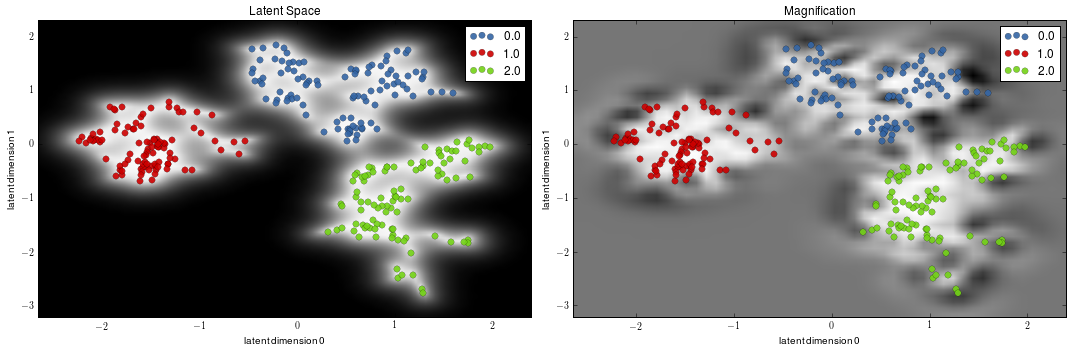

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
v1 = m_gplvm.plot_latent(labels=labels, ax=axes[0], updates=False, resolution=100)
axes[0].set_title('Latent Space')
v2 = m_gplvm.plot_magnification(labels=labels, ax=axes[1], updates=False)
axes[1].set_title('Magnification')

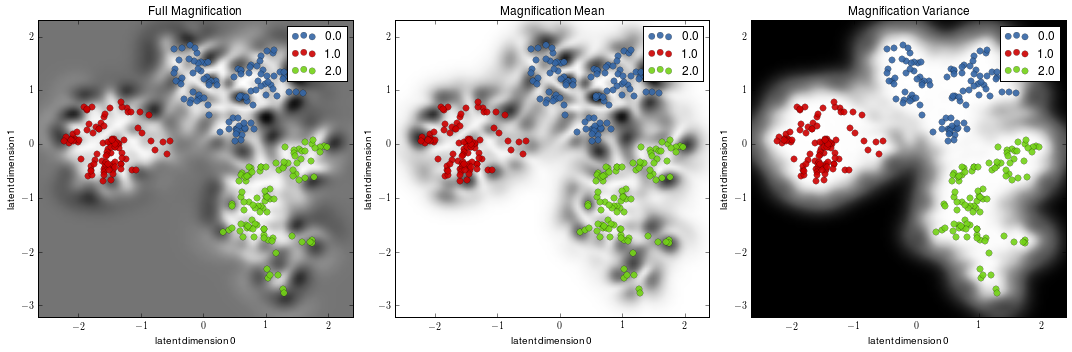

In [6]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
#pl = (-5,5,-5,5)
pl = None
ax = axes[0]
v1 = m_gplvm.plot_magnification(ax=ax, resolution=120, 
                      plot_inducing=True, covariance=True, 
                      plot_limits=pl, updates=False,
                      labels = labels,
                     )
ax.set_title("Full Magnification")

ax = axes[1]
v2 = m_gplvm.plot_magnification(ax=ax, 
                      plot_inducing=True, resolution=120, covariance=False,
                      plot_limits=pl, updates=False,
                      labels = labels,
                     )
ax.set_title("Magnification Mean")

ax = axes[2]
v3 = m_gplvm.plot_magnification(ax=ax, resolution=120, 
                      plot_inducing=True, mean=False, 
                      plot_limits=pl, updates=False,
                      labels = labels,
                     )
ax.set_title("Magnification Variance")

As you can see, the magnification factor tells us about the 'bending' of the embedding. Where there is data, the embedding is dense and bends towards the data. This means the magnification shows us, how the plane got warped (with the data pinned on it) to recreate the latent space. You can see the magnification as stretching and bending. The higher the magnification the more stretched the space is at those places. Still, you need to keep in mind, that the magnification is summarized for all latent dimensions and therefore not always full represents what is going on, as a stretching in one dimension could be counteracted by a contraction of another. 

#### Bayesian GPLVM:

We can plot the magnification also for the Bayesian GPLVM. Here it is defined through the inducing inputs, shown as little white triangles in the plot. You can see, that the magnification evolves around the inducing inputs.

In [7]:
m = GPy.models.bayesian_gplvm_minibatch.BayesianGPLVMMiniBatch(Y, input_dim, num_inducing=30, missing_data=True)

In [8]:
m.optimize(messages=1, max_iters=5e3)

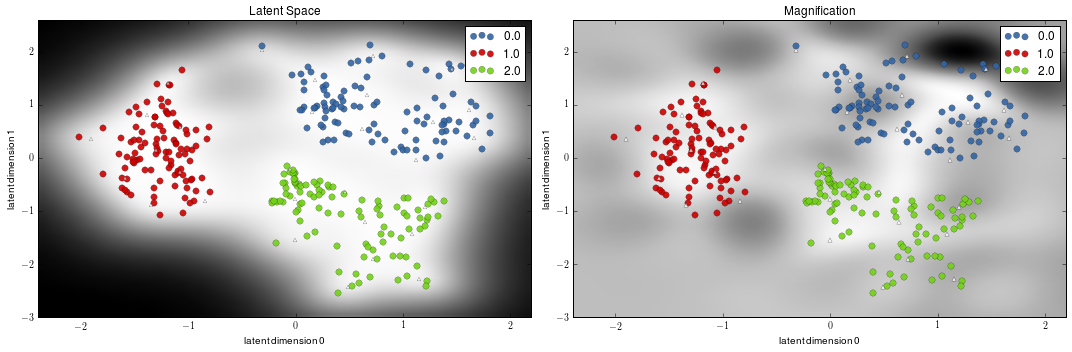

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_title('Latent Space')
v1 = m.plot_latent(labels=labels, ax=axes[0], updates=False)
axes[1].set_title('Magnification')
v2 = m.plot_magnification(labels=labels, ax=axes[1], updates=False, resolution=120)

The Magnification factor is less fine graned, as it goes through the inducing inputs, instead of through every datapoint. Still you can see, the structure of the magnification factor, being less bent, where there is data nd bending towards data. Where there is not data, the magnification (and therefore the embedding) is flat.

### Stick demo:
Running the stick demo code and plotting the magnification factor for it:

In [10]:
m_stick = GPy.examples.dimensionality_reduction.stick_bgplvm(plot=False)

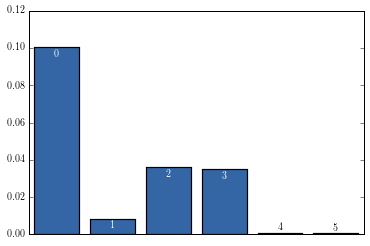

In [11]:
m_stick.kern.plot_ARD()

In [12]:
m.Z.randomize()
m.kern.randomize()
m_stick.optimize(messages=1)

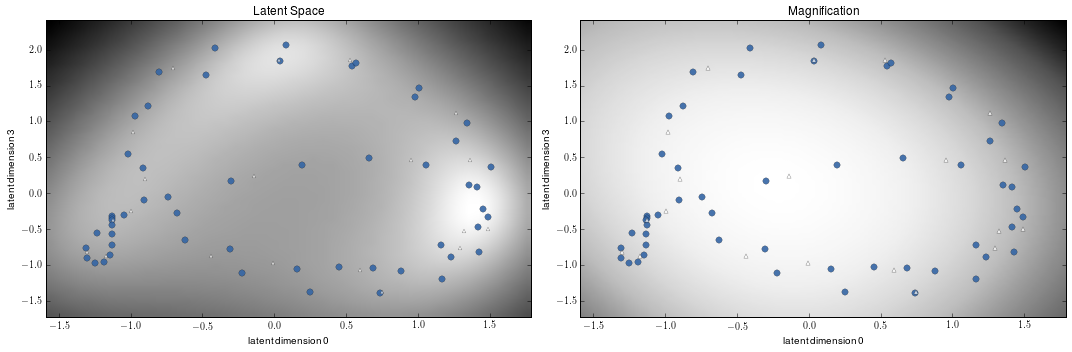

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
wi = [0,3]
axes[0].set_title('Latent Space')
v1 = m_stick.plot_latent(labels=None, ax=axes[0], updates=False, which_indices=wi)
axes[1].set_title('Magnification')
v2 = m_stick.plot_magnification(labels=None, ax=axes[1], updates=False, resolution=120, which_indices=wi)

### Oil Flow Data:
Running the Oil Flow dataset

In [14]:
m_oil = GPy.examples.dimensionality_reduction.bgplvm_oil(N=300, plot=False)

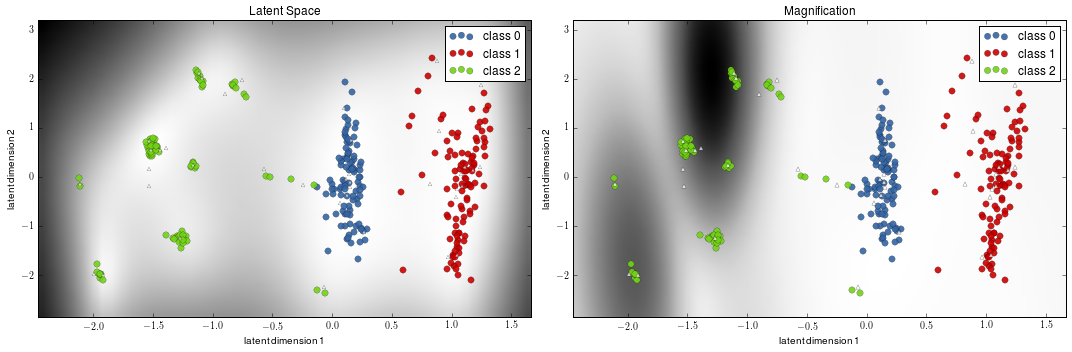

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes[0].set_title('Latent Space')
v1 = m_oil.plot_latent(labels=m_oil.data_labels, ax=axes[0], updates=False)
axes[1].set_title('Magnification')
v2 = m_oil.plot_magnification(labels=m_oil.data_labels, ax=axes[1], updates=False, resolution=120)

Here  we can see, that in order to seperate class 2 out from the data, the BayesianGPLVM needed to stretch thin and the manifold is bent around class 2 the most, whereas it did not have to bend as much to seperate class 0 and 1. 